In [14]:
import os
import glob

import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from dynamic_routing_analysis import decoding_utils #, plot_utils
import dynamic_routing_analysis as dra
import npc_lims

plt.rcParams['pdf.fonttype'] = 42 

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# set path to decoding results
# loadpath = dra.DECODING_ROOT_PATH / "new_annotations" / "linear_shift_20_units"
# loadpath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\shailaja\population_decoding"
# loadpath=r"\\allen\programs\mindscope\workgroups\templeton\TTOC\decoding results\new_annotations\linear_shift_20_units_plus_all"
# loadpath=r"D:\decoding_results_from_CO\2024-10-11"
loadpath=r"D:\decoding_results_from_CO\logreg_many_n_units_medium_criteria_2025-01-08"
files=glob.glob(os.path.join(loadpath,'*_decoder_confidence*.pkl'))

In [ ]:
# load all trialwise decoding results, option to concatenate all sessions
concat_session_results=False
save_tables=False
return_table=False

n_units='_20_units'

# loadpath = (
#     dra.DECODING_ROOT_PATH
#     / "new_annotations"
#     / "linear_shift_20_units"
#     / "combined" 
#     / "no_normalization"
# )
# loadpath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\shailaja\population_decoding"
# loadpath=r"\\allen\programs\mindscope\workgroups\templeton\TTOC\decoding results\new_annotations\linear_shift_20_units_plus_all"
if save_tables:
    savepath=loadpath #os.path.join(loadpath,'combined')
else:
    savepath=None

if concat_session_results:
    combined_results=decoding_utils.concat_trialwise_decoder_results(files[0:1],savepath=savepath,return_table=return_table,n_units='all',single_session=True)
    if return_table:
        response_type_predict_proba=combined_results[0]
        decoder_confidence_dprime_by_block=combined_results[1]
        decoder_confidence_by_switch=combined_results[2]
        decoder_confidence_versus_trials_since_rewarded_target=combined_results[3]
        before_after_target_predict_proba=combined_results[4]
else:
    # response_type_predict_proba=pd.read_csv(os.path.join(loadpath,'response_type_predict_proba.csv'))
    # decoder_confidence_dprime_by_block=pd.read_csv(os.path.join(loadpath,'decoder_confidence_dprime_by_block.csv'))
    # decoder_confidence_by_switch=pd.read_csv(os.path.join(loadpath,'decoder_predict_proba_by_switch.csv'))
    # decoder_confidence_versus_trials_since_rewarded_target=pd.read_csv(os.path.join(loadpath,'decoder_confidence_versus_trials_since_rewarded_target.csv'))
    # before_after_target_predict_proba=pd.read_csv(os.path.join(loadpath,'before_after_target_predict_proba.csv'))
    response_type_predict_proba=pd.read_pickle(os.path.join(loadpath,'response_type_predict_proba'+n_units+'.pkl'))
    decoder_confidence_dprime_by_block=pd.read_pickle(os.path.join(loadpath,'decoder_confidence_dprime_by_block'+n_units+'.pkl'))
    decoder_confidence_by_switch=pd.read_pickle(os.path.join(loadpath,'decoder_confidence_by_switch'+n_units+'.pkl'))
    decoder_confidence_versus_trials_since_rewarded_target=pd.read_pickle(os.path.join(loadpath,'decoder_confidence_versus_trials_since_rewarded_target'+n_units+'.pkl'))
    before_after_target_predict_proba=pd.read_pickle(os.path.join(loadpath,'before_after_target_predict_proba'+n_units+'.pkl'))
    decoder_confidence_all_trials=pd.read_pickle(os.path.join(loadpath,'decoder_confidence_all_trials'+n_units+'.pkl'))



In [ ]:
type(files[0:1])

In [ ]:
# #plot variance across repeats
# import upath
# example_rec=upath.UPath('s3://aind-scratch-data/dynamic-routing/ethan/decoding-results/logreg_many_n_units_medium_criteria_2025-01-08/686176_2023-12-07_2025-01-08.pkl')

# # Load the example file with pickle
# import pickle
# example_data=pickle.loads(example_rec.read_bytes())

MemoryError: 

In [2]:
# #save example locally so I don't have to re-download
# example_savepath=r"D:\decoding_results_from_CO\example session from 2025-01-08\686176_2023-12-07_2025-01-08.pkl"

# with open(example_savepath, 'wb') as f:
#     pickle.dump(example_data, f)

In [1]:
# example_data.keys()

## plot correct reject minus false alarm decoder confidence across areas

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15896\1287702840.py:26: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  cr_fa_diff_by_area['vis_context_cr_fa_diff_sem'].append(stats.sem(sel_area['vis_cr_confidence']-sel_area['vis_fa_confidence']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15896\1287702840.py:29: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  cr_fa_diff_by_area['aud_context_cr_fa_diff_sem'].append(stats.sem(sel_area['aud_cr_confidence']-sel_area['aud_fa_confidence']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15896\1287702840.py:33: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  cr_fa_diff_by_area['mean_diff_sem'].append(stats.sem(mean_diffs))
C:\Users\eth

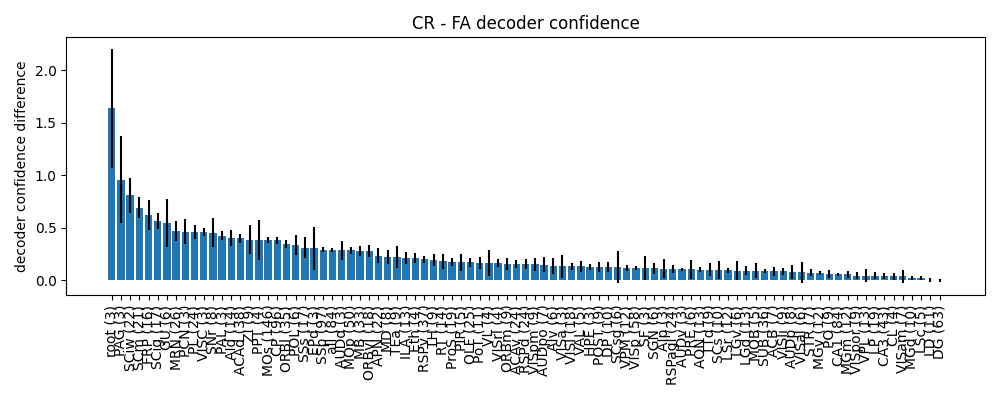

In [ ]:
sel_project='DynamicRouting'
min_n_sessions=3
min_n_good_blocks=4

cr_fa_diff_by_area={
    'area':[],
    'n_sessions':[],
    'vis_context_dprime':[],
    'vis_context_cr_fa_diff':[],
    'vis_context_cr_fa_diff_sem':[],
    'aud_context_dprime':[],
    'aud_context_cr_fa_diff':[],
    'aud_context_cr_fa_diff_sem':[],
    'mean_diff':[],
    'mean_diff_sem':[],
    'total_diff':[],
}

for aa in response_type_predict_proba['area'].unique():
    
    sel_area=response_type_predict_proba.query('area==@aa and n_good_blocks>=@min_n_good_blocks and project.str.contains(@sel_project)')
    cr_fa_diff_by_area['area'].append(aa)
    cr_fa_diff_by_area['n_sessions'].append(len(sel_area))
    cr_fa_diff_by_area['vis_context_dprime'].append(np.mean(sel_area['vis_context_dprime']))
    cr_fa_diff_by_area['vis_context_cr_fa_diff'].append(np.mean(sel_area['vis_cr_confidence']-sel_area['vis_fa_confidence']))
    cr_fa_diff_by_area['vis_context_cr_fa_diff_sem'].append(stats.sem(sel_area['vis_cr_confidence']-sel_area['vis_fa_confidence']))
    cr_fa_diff_by_area['aud_context_dprime'].append(np.mean(sel_area['aud_context_dprime']))
    cr_fa_diff_by_area['aud_context_cr_fa_diff'].append(np.mean(sel_area['aud_cr_confidence']-sel_area['aud_fa_confidence']))
    cr_fa_diff_by_area['aud_context_cr_fa_diff_sem'].append(stats.sem(sel_area['aud_cr_confidence']-sel_area['aud_fa_confidence']))
    cr_fa_diff_by_area['mean_diff'].append(np.mean([cr_fa_diff_by_area['vis_context_cr_fa_diff'][-1],-cr_fa_diff_by_area['aud_context_cr_fa_diff'][-1]]))

    mean_diffs=(sel_area['vis_cr_confidence'].values+sel_area['aud_cr_confidence'].values)/2-(sel_area['vis_fa_confidence'].values+sel_area['aud_fa_confidence'].values)/2
    cr_fa_diff_by_area['mean_diff_sem'].append(stats.sem(mean_diffs))

    cr_fa_diff_by_area['total_diff'].append(np.sum([np.abs(cr_fa_diff_by_area['vis_context_cr_fa_diff'][-1]),np.abs(cr_fa_diff_by_area['aud_context_cr_fa_diff'][-1])]))


cr_fa_diff_by_area=pd.DataFrame(cr_fa_diff_by_area)

plot_data=cr_fa_diff_by_area.query('n_sessions>=@min_n_sessions').sort_values(by='mean_diff',ascending=False)

fig,ax=plt.subplots(figsize=(10,4))
ax.bar(plot_data['area'],plot_data['mean_diff'],yerr=plot_data['mean_diff_sem'])

area_labels=[]
for i in range(plot_data.shape[0]):
    area_labels.append(plot_data['area'].iloc[i]+' ('+str(plot_data['n_sessions'].iloc[i])+')')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(area_labels,rotation=90,ha='center')
ax.set_ylabel('decoder confidence difference')

ax.set_title('CR - FA decoder confidence')

fig.tight_layout()


## correct - incorrect decoder confidence across areas

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15896\573162211.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  correct_incorrect_diff_by_area['correct_incorrect_diff_sem'].append(stats.sem(sel_area['correct_confidence']-sel_area['incorrect_confidence']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15896\573162211.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  correct_incorrect_diff_by_area['correct_incorrect_diff_sem'].append(stats.sem(sel_area['correct_confidence']-sel_area['incorrect_confidence']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15896\573162211.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  correct_incorrect_diff_by_area['correct_incorrect

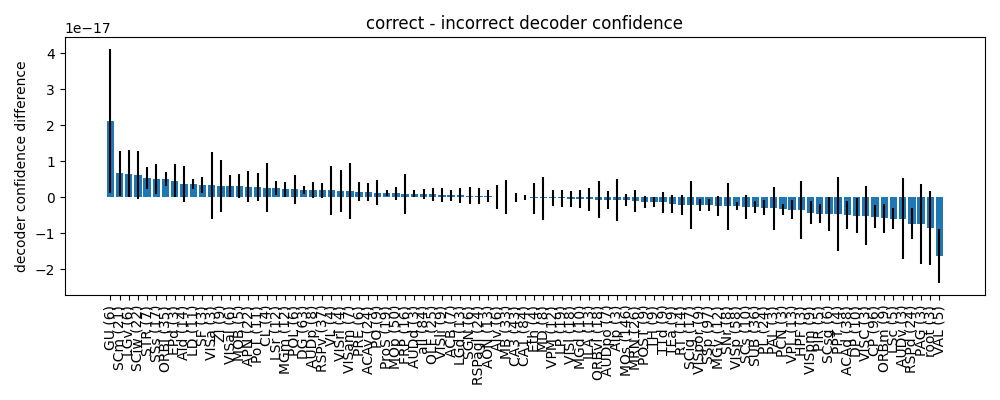

In [ ]:
sel_project='DynamicRouting'
min_n_sessions=3
min_n_good_blocks=4

correct_incorrect_diff_by_area={
    'area':[],
    'n_sessions':[],
    'dprime':[],
    'correct_incorrect_diff':[],
    'correct_incorrect_diff_sem':[],

}

for aa in response_type_predict_proba['area'].unique():
    sel_area=response_type_predict_proba.query('area==@aa and n_good_blocks>=@min_n_good_blocks and project.str.contains(@sel_project)')
    correct_incorrect_diff_by_area['area'].append(aa)
    correct_incorrect_diff_by_area['n_sessions'].append(len(sel_area))
    correct_incorrect_diff_by_area['dprime'].append(np.mean(sel_area['overall_dprime']))
    correct_incorrect_diff_by_area['correct_incorrect_diff'].append(np.mean(sel_area['correct_confidence']-sel_area['incorrect_confidence']))
    correct_incorrect_diff_by_area['correct_incorrect_diff_sem'].append(stats.sem(sel_area['correct_confidence']-sel_area['incorrect_confidence']))

correct_incorrect_diff_by_area=pd.DataFrame(correct_incorrect_diff_by_area)

plot_data=correct_incorrect_diff_by_area.query('n_sessions>=@min_n_sessions').sort_values(by='correct_incorrect_diff',ascending=False)

fig,ax=plt.subplots(figsize=(10,4))
ax.bar(plot_data['area'],plot_data['correct_incorrect_diff'],yerr=plot_data['correct_incorrect_diff_sem'])

area_labels=[]
for i in range(plot_data.shape[0]):
    area_labels.append(plot_data['area'].iloc[i]+' ('+str(plot_data['n_sessions'].iloc[i])+')')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(area_labels,rotation=90,ha='center')
ax.set_ylabel('decoder confidence difference')
ax.set_title('correct - incorrect decoder confidence')

fig.tight_layout()


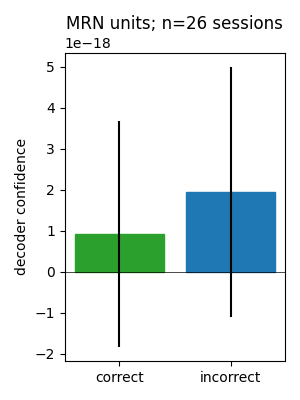

In [ ]:
#correct vs. incorrect

#select area
aa='MRN'

sel_project='DynamicRouting'
min_n_recs=3
min_n_good_blocks=4

sel_area=response_type_predict_proba.query('area==@aa and n_good_blocks>=@min_n_good_blocks and project.str.contains(@sel_project)')

fig,ax=plt.subplots(1,1,figsize=(3,4))
ax.axhline(0,color='k',linewidth=0.5)
bars=ax.bar([0,1],sel_area[['correct_confidence','incorrect_confidence',]].mean().values)
ax.errorbar([0,1],sel_area[['correct_confidence','incorrect_confidence']].mean().values,
            yerr=sel_area[['correct_confidence','incorrect_confidence',]].sem().values,linestyle='',color='k')
ax.set_xticks([0,1])
ax.set_xticklabels(['correct','incorrect'])
bars[0].set_color('tab:green')
bars[1].set_color('tab:blue')

ax.set_title(str(aa)+' units; n='+str(len(sel_area))+' sessions')
# ax.set_ylim([0,0.4])
ax.set_ylabel('decoder confidence')
fig.tight_layout()

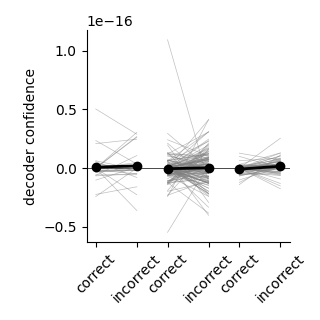

In [ ]:
#compare multiple areas - raw vs. null decoding

area1='MRN'
area2='MOs'
area3='VISp'

sel_project='DynamicRouting'
min_n_recs=3
min_n_good_blocks=4

sel_area1=response_type_predict_proba.query('area==@area1 and n_good_blocks>=@min_n_good_blocks and project.str.contains(@sel_project)')
sel_area2=response_type_predict_proba.query('area==@area2 and n_good_blocks>=@min_n_good_blocks and project.str.contains(@sel_project)')
sel_area3=response_type_predict_proba.query('area==@area3 and n_good_blocks>=@min_n_good_blocks and project.str.contains(@sel_project)')

fig,ax=plt.subplots(1,1,figsize=(3.2,3.2))
ax.axhline(0,color='k',linewidth=0.5)

ax.plot([0,1],[sel_area1['correct_confidence'],sel_area['incorrect_confidence']],'grey',alpha=0.5,linewidth=0.5)
ax.plot([0,1],[sel_area1['correct_confidence'].mean(),sel_area1['incorrect_confidence'].mean()],'k-o',linewidth=2)
ax.plot([1.75,2.75],[sel_area2['correct_confidence'],sel_area2['incorrect_confidence']],'grey',alpha=0.5,linewidth=0.5)
ax.plot([1.75,2.75],[sel_area2['correct_confidence'].mean(),sel_area2['incorrect_confidence'].mean()],'k-o',linewidth=2)
ax.plot([3.5,4.5],[sel_area3['correct_confidence'],sel_area3['incorrect_confidence']],'grey',alpha=0.5,linewidth=0.5)
ax.plot([3.5,4.5],[sel_area3['correct_confidence'].mean(),sel_area3['incorrect_confidence'].mean()],'k-o',linewidth=2)

ax.set_xticks([0,1,1.75,2.75,3.5,4.5])
ax.set_xticklabels(['correct','incorrect','correct','incorrect','correct','incorrect'],rotation=45)

ax.set_ylabel('decoder confidence')

#remove spines
# ax.set_ylim([-0.1,0.6])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()

In [10]:
# #save figure
# savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-09-25-plots_for_SFN_poster"
# fig.savefig(os.path.join(savepath,area1+'_'+area2+'_'+area3+'_decoder_confidence_.png'),format='png',dpi=600)

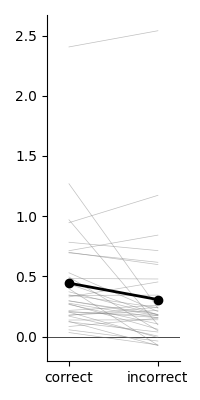

In [ ]:
##plot single area

area1='MRN'

sel_project='DynamicRouting'
min_n_recs=3
min_n_good_blocks=4

sel_area1=response_type_predict_proba.query('area==@area1 and n_good_blocks>=@min_n_good_blocks and project.str.contains(@sel_project)')

fig,ax=plt.subplots(1,1,figsize=(2,4))
ax.axhline(0,color='k',linewidth=0.5)

ax.plot([0,1],[sel_area1['correct_confidence'],sel_area1['incorrect_confidence']],'grey',alpha=0.5,linewidth=0.5)
ax.plot([0,1],[sel_area1['correct_confidence'].mean(),sel_area1['incorrect_confidence'].mean()],'k-o',linewidth=2)

ax.set_xticks([0,1])
ax.set_xticklabels(['correct','incorrect'])

#remove spines
# ax.set_ylim([-0.2,0.6])
ax.set_xlim(-0.25,1.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

In [7]:
##TODO: plot/validate other trialwise analyses

## plot predict probability

In [13]:
decoder_confidence_all_trials

,session,area,project,probe,cross_modal_dprime,n_good_blocks,trial_index,confidence,predict_proba,ccf_ap_mean,ccf_dv_mean,ccf_ml_mean,n_units
0,620263_2022-07-26,DG,TempletonPilotSession,,NaN,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.633973551020234, 0.1897283509118274, 0.5583...","[0.598842891868319, 0.5214440346869513, 0.5768...",8310.542169,2863.253012,3189.759036,83
1,620263_2022-07-26,CA1,TempletonPilotSession,B,NaN,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-0.017825619377879725, 0.8728142699133936, 2....","[0.48939906821085727, 0.6804677444769616, 0.70...",8389.552239,1892.164179,3311.940299,67
2,620263_2022-07-26,VISp,TempletonPilotSession,,NaN,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0718289188854475, 1.3397289381630912, 0.739...","[0.7069663181522203, 0.6903215523241844, 0.646...",8379.956897,1102.370690,3442.456897,116
3,620263_2022-07-26,CA1,TempletonPilotSession,C,NaN,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[2.495746654757283, 0.7644917603779223, 0.7666...","[0.8057202563844331, 0.6312865257072598, 0.647...",8327.397260,3666.780822,1863.698630,146
4,620263_2022-07-26,TEa,TempletonPilotSession,,NaN,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9152233240747419, 0.7419807793278537, 1.302...","[0.6683237038454021, 0.6423792180255531, 0.764...",8640.217391,2378.260870,1814.492754,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,742903_2024-10-24,MOp,DynamicRouting,,2.339739,5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-0.14579500653781602, -0.3358121577512655, -0...","[0.4786210976389054, 0.4183672811744888, 0.329...",4101.056338,2594.014085,3239.084507,142
16,742903_2024-10-24,all,DynamicRouting,,2.339739,5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-1.220148078728816, -1.713272540241461, -1.88...","[0.30197712681691136, 0.23911392657725666, 0.2...",6452.969208,3147.140762,2822.452346,1365
17,742903_2024-10-24,CA1,DynamicRouting,all,2.339739,5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-2.7676298934815686, -3.1577544236939947, -2....","[0.11693431648689862, 0.13171468343517556, 0.1...",7710.416667,2355.208333,2661.458333,48
18,742903_2024-10-24,CP,DynamicRouting,all,2.339739,5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-0.11377123324703266, -1.1734378721406766, -1...","[0.5159826789392902, 0.31359777422240637, 0.26...",5323.052960,4030.841121,3302.414330,321


In [ ]:
#make a table of predict_proba for each confidence switch 

n_trials_before_switch=80
n_trials_after_switch=80
context_switch_predict_proba={
    'area':[],
    'session_id':[],
    'project':[],
    'switch_index':[],
    'trial_index':[],
    'context_before':[],
    'context_after':[],
    'dprime_before':[],
    'dprime_after':[],
    'ccf_ap_mean':[],
    'ccf_dv_mean':[],
    'ccf_ml_mean':[],
    'predict_proba':[],
    'n_units':[],
}

#predict proba mean for each response type
response_type_predict_proba={
    'session_id':[],
    'area':[],
    'project':[],
    'vis_context_dprime':[],
    'aud_context_dprime':[],
    'overall_dprime':[],
    'n_good_blocks':[],

    'vis_hit_predict_proba':[],
    'vis_fa_predict_proba':[],
    'vis_cr_predict_proba':[],
    'aud_hit_predict_proba':[],
    'aud_fa_predict_proba':[],
    'aud_cr_predict_proba':[],
    'correct_predict_proba':[],
    'incorrect_predict_proba':[],
    'cr_all_predict_proba':[],
    'fa_all_predict_proba':[],
    'hit_all_predict_proba':[],

    'ccf_ap_mean':[],
    'ccf_dv_mean':[],
    'ccf_ml_mean':[],
    'n_units':[],
}

#predict proba mean for each response type
response_type_blockwise_predict_proba={
    'session_id':[],
    'area':[],
    'project':[],
    'block_number':[],
    'is_vis_context':[],
    'is_aud_context':[],
    'block_dprime':[],

    'hit_predict_proba':[],
    'fa_predict_proba':[],
    'cr_predict_proba':[],
    'correct_predict_proba':[],
    'incorrect_predict_proba':[],

    'ccf_ap_mean':[],
    'ccf_dv_mean':[],
    'ccf_ml_mean':[],
    'n_units':[],
}

#before and after target/non target predict proba
before_after_target_predict_proba={
    'session_id':[],
    'area':[],
    'project':[],
    'cross_modal_dprime':[],
    'n_good_blocks':[],
    'rewarded_target':[],
    'rewarded_target_plus_one':[],
    'non_rewarded_target':[],
    'non_rewarded_target_plus_one':[],
    'non_response_non_rewarded_target':[],
    'non_response_non_rewarded_target_plus_one':[],
    'non_response_non_target_trials':[],
    'non_response_non_target_trials_plus_one':[],
    'ccf_ap_mean':[],
    'ccf_dv_mean':[],
    'ccf_ml_mean':[],
    'n_units':[],
}

sel_project='DynamicRouting'
unique_sessions=decoder_confidence_all_trials.query('project==@sel_project')['session'].unique()

# #for each unique session
for session_id in unique_sessions:

    # session_id=unique_sessions[0]

    session_confidence=decoder_confidence_all_trials.query('session==@session_id and (probe=="" or probe=="all")')

    #load trials table & performance table
    trials=pd.read_parquet(npc_lims.get_cache_path('trials',version='0.0.265',session_id=session_id))
    performance=pd.read_parquet(npc_lims.get_cache_path('performance',version='0.0.265',session_id=session_id))

    ### SWITCH ALIGNED PREDICT PROBA ###
    #find block switches
    block_switches=trials.query('is_context_switch').index.values
    #for each area (not including those with probe letters)
    session_areas=session_confidence['area'].unique()

    for aa in session_areas:
        # aa=session_areas[0]
        area_confidence=session_confidence.query('area==@aa')
        area_predict_proba=area_confidence['predict_proba'].values[0]

        #for each switch
        for ss,switch in enumerate(block_switches):
            # switch=block_switches[0]
            # ss=0
            dprime_before=performance['cross_modal_dprime'].iloc[ss]
            dprime_after=performance['cross_modal_dprime'].iloc[ss+1]
            context_before=trials['context_name'].iloc[switch-1]
            context_after=trials['context_name'].iloc[switch]

            #save variables
            context_switch_predict_proba['area'].append(aa)
            context_switch_predict_proba['session_id'].append(session_id)
            context_switch_predict_proba['project'].append(session_confidence['project'].values[0])
            context_switch_predict_proba['switch_index'].append(ss)
            context_switch_predict_proba['trial_index'].append(switch)
            context_switch_predict_proba['context_before'].append(context_before)
            context_switch_predict_proba['context_after'].append(context_after)
            context_switch_predict_proba['dprime_before'].append(dprime_before)
            context_switch_predict_proba['dprime_after'].append(dprime_after)
            context_switch_predict_proba['ccf_ap_mean'].append(area_confidence['ccf_ap_mean'].values)
            context_switch_predict_proba['ccf_dv_mean'].append(area_confidence['ccf_dv_mean'].values)
            context_switch_predict_proba['ccf_ml_mean'].append(area_confidence['ccf_ml_mean'].values)
            # #check if trials exist
            if switch-n_trials_before_switch<0:
                #if not, take the first n_trials_before_switch trials
                switch_predict_proba=area_predict_proba[0:switch+n_trials_after_switch]
                #pad with nans
                switch_predict_proba=np.concatenate((np.full((n_trials_before_switch-switch),np.nan),switch_predict_proba))

            elif switch+n_trials_after_switch>len(area_predict_proba):
                #if not, take the last n_trials_after_switch trials
                switch_predict_proba=area_predict_proba[switch-n_trials_before_switch:len(area_predict_proba)]
                #pad with nans
                switch_predict_proba=np.concatenate((switch_predict_proba,np.full((switch+n_trials_after_switch-len(area_predict_proba)),np.nan)))

            else:
                switch_predict_proba=area_predict_proba[switch-n_trials_before_switch:switch+n_trials_after_switch]
                
            context_switch_predict_proba['predict_proba'].append(switch_predict_proba)
            context_switch_predict_proba['n_units'].append(area_confidence['n_units'].values[0])

    
        ### RESPONSE TYPE PREDICT PROBA ###

        #get trial indices for each type
        vis_HIT_idx=trials.query('(is_correct==True and is_target==True and is_vis_context==True \
                                    and is_response==True and is_reward_scheduled==False)').index.values
        aud_HIT_idx=trials.query('(is_correct==True and is_target==True and is_vis_context==False \
                                    and is_response==True and is_reward_scheduled==False)').index.values
        vis_CR_idx=trials.query('(is_correct==True and is_target==True and is_vis_context==True \
                                    and is_response==False and is_reward_scheduled==False)').index.values
        aud_CR_idx=trials.query('(is_correct==True and is_target==True and is_vis_context==False \
                                    and is_response==False and is_reward_scheduled==False)').index.values
        vis_FA_idx=trials.query('(is_correct==False and is_target==True and is_vis_context==True \
                                    and is_response==True and is_reward_scheduled==False)').index.values
        aud_FA_idx=trials.query('(is_correct==False and is_target==True and is_vis_context==False \
                                    and is_response==True and is_reward_scheduled==False)').index.values

        correct_vis_idx=trials.query('is_correct==True and is_target==True and is_reward_scheduled==False').index.values
        incorrect_vis_idx=trials.query('is_correct==False and is_target==True and is_reward_scheduled==False').index.values
        correct_aud_idx=trials.query('is_correct==True and is_target==True and is_reward_scheduled==False').index.values
        incorrect_aud_idx=trials.query('is_correct==False and is_target==True and is_reward_scheduled==False').index.values

        #find average predict_proba per hit, fa, cr
        vis_HIT_proba_mean=np.nanmean(area_predict_proba[vis_HIT_idx])
        aud_HIT_proba_mean=np.nanmean(area_predict_proba[aud_HIT_idx])
        vis_CR_proba_mean=np.nanmean(area_predict_proba[vis_CR_idx])
        aud_CR_proba_mean=np.nanmean(area_predict_proba[aud_CR_idx])
        vis_FA_proba_mean=np.nanmean(area_predict_proba[vis_FA_idx])
        aud_FA_proba_mean=np.nanmean(area_predict_proba[aud_FA_idx])

        correct_proba_mean=np.nanmean(np.hstack([area_predict_proba[correct_vis_idx],1-area_predict_proba[correct_aud_idx]]))
        incorrect_proba_mean=np.nanmean(np.hstack([area_predict_proba[incorrect_vis_idx],1-area_predict_proba[incorrect_aud_idx]]))

        CR_all_proba_mean=np.nanmean(np.hstack([area_predict_proba[vis_CR_idx],1-area_predict_proba[aud_CR_idx]]))
        FA_all_proba_mean=np.nanmean(np.hstack([area_predict_proba[vis_FA_idx],1-area_predict_proba[aud_FA_idx]]))
        HIT_all_proba_mean=np.nanmean(np.hstack([area_predict_proba[vis_HIT_idx],1-area_predict_proba[aud_HIT_idx]]))

        #save variables
        response_type_predict_proba['session_id'].append(session_id)
        response_type_predict_proba['area'].append(aa)
        response_type_predict_proba['project'].append(session_confidence['project'].values[0])
        if performance.query('rewarded_modality=="vis"').empty:
            response_type_predict_proba['vis_context_dprime'].append(np.nan)
        else:
            response_type_predict_proba['vis_context_dprime'].append(performance.query('rewarded_modality=="vis"')['cross_modal_dprime'].values[0])
        if performance.query('rewarded_modality=="aud"').empty:
            response_type_predict_proba['aud_context_dprime'].append(np.nan)
        else:
            response_type_predict_proba['aud_context_dprime'].append(performance.query('rewarded_modality=="aud"')['cross_modal_dprime'].values[0])
        response_type_predict_proba['overall_dprime'].append(performance['cross_modal_dprime'].mean())
        response_type_predict_proba['n_good_blocks'].append(performance.query('cross_modal_dprime>=1.0')['cross_modal_dprime'].count())

        response_type_predict_proba['vis_hit_predict_proba'].append(vis_HIT_proba_mean)
        response_type_predict_proba['aud_hit_predict_proba'].append(aud_HIT_proba_mean)
        response_type_predict_proba['vis_cr_predict_proba'].append(vis_CR_proba_mean)
        response_type_predict_proba['aud_cr_predict_proba'].append(aud_CR_proba_mean)
        response_type_predict_proba['vis_fa_predict_proba'].append(vis_FA_proba_mean)
        response_type_predict_proba['aud_fa_predict_proba'].append(aud_FA_proba_mean)
        response_type_predict_proba['correct_predict_proba'].append(correct_proba_mean)
        response_type_predict_proba['incorrect_predict_proba'].append(incorrect_proba_mean)
        response_type_predict_proba['cr_all_predict_proba'].append(CR_all_proba_mean)
        response_type_predict_proba['fa_all_predict_proba'].append(FA_all_proba_mean)
        response_type_predict_proba['hit_all_predict_proba'].append(HIT_all_proba_mean)

        response_type_predict_proba['ccf_ap_mean'].append(area_confidence['ccf_ap_mean'].values)
        response_type_predict_proba['ccf_dv_mean'].append(area_confidence['ccf_dv_mean'].values)
        response_type_predict_proba['ccf_ml_mean'].append(area_confidence['ccf_ml_mean'].values)
        response_type_predict_proba['n_units'].append(area_confidence['n_units'].values[0])


        ### RESPONSE TYPE BLOCKWISE PREDICT PROBA ###
        #for each block
        blocks=trials['block_index'].unique()
        for bb,block in enumerate(blocks):

            block_trials=trials.query('block_index==@block')
            block_performance=performance.query('block_index==@block')

            HIT_idx=block_trials.query('(is_correct==True and is_target==True \
                                        and is_response==True and is_reward_scheduled==False)').index.values
            CR_idx=block_trials.query('(is_correct==True and is_target==True \
                                        and is_response==False and is_reward_scheduled==False)').index.values
            FA_idx=block_trials.query('(is_correct==False and is_target==True \
                                        and is_response==True and is_reward_scheduled==False)').index.values

            correct_idx=block_trials.query('is_correct==True and is_target==True and is_reward_scheduled==False').index.values
            incorrect_idx=block_trials.query('is_correct==False and is_target==True and is_reward_scheduled==False').index.values

            #find average predict_proba per hit, fa, cr
            HIT_proba_mean=np.nanmean(area_predict_proba[HIT_idx])
            CR_proba_mean=np.nanmean(area_predict_proba[CR_idx])
            FA_proba_mean=np.nanmean(area_predict_proba[FA_idx])

            correct_proba_mean=np.nanmean(np.hstack([area_predict_proba[correct_idx],1-area_predict_proba[correct_aud_idx]]))
            incorrect_proba_mean=np.nanmean(np.hstack([area_predict_proba[incorrect_idx],1-area_predict_proba[incorrect_aud_idx]]))

            #save variables
            response_type_blockwise_predict_proba['session_id'].append(session_id)
            response_type_blockwise_predict_proba['area'].append(aa)
            response_type_blockwise_predict_proba['project'].append(session_confidence['project'].values[0])
            response_type_blockwise_predict_proba['block_number'].append(bb)
            response_type_blockwise_predict_proba['is_vis_context'].append(block_performance['rewarded_modality'].values[0]=='vis')
            response_type_blockwise_predict_proba['is_aud_context'].append(block_performance['rewarded_modality'].values[0]=='aud')
            response_type_blockwise_predict_proba['block_dprime'].append(block_performance['cross_modal_dprime'].values[0])

            response_type_blockwise_predict_proba['hit_predict_proba'].append(HIT_proba_mean)
            response_type_blockwise_predict_proba['cr_predict_proba'].append(CR_proba_mean)
            response_type_blockwise_predict_proba['fa_predict_proba'].append(FA_proba_mean)
            response_type_blockwise_predict_proba['correct_predict_proba'].append(correct_proba_mean)
            response_type_blockwise_predict_proba['incorrect_predict_proba'].append(incorrect_proba_mean)

            response_type_blockwise_predict_proba['ccf_ap_mean'].append(area_confidence['ccf_ap_mean'].values)
            response_type_blockwise_predict_proba['ccf_dv_mean'].append(area_confidence['ccf_dv_mean'].values)
            response_type_blockwise_predict_proba['ccf_ml_mean'].append(area_confidence['ccf_ml_mean'].values)
            response_type_blockwise_predict_proba['n_units'].append(area_confidence['n_units'].values[0])



        ### BEFORE/AFTER TARGET PREDICT PROBA ###
        #decoder confidence before/after rewarded target, response to non-rewarded target, non-response to non-rewarded target
        predict_proba_current_context=area_predict_proba.copy()
        for tt,trial in trials.iterrows():
            if trial['is_aud_context']:
                predict_proba_current_context[tt]=1-predict_proba_current_context[tt]
        #find trial and trial+1 of rewarded targets
        rewarded_target_trials=trials.query('is_rewarded==True and is_target==True and is_response==True and is_reward_scheduled==False').index.values
        rewarded_target_trials_plus_one=rewarded_target_trials+1
        if len(rewarded_target_trials_plus_one)>0:
            if rewarded_target_trials_plus_one[-1]>=len(area_predict_proba):
                rewarded_target_trials=rewarded_target_trials[:-1]
                rewarded_target_trials_plus_one=rewarded_target_trials_plus_one[:-1]

        #find trials and trials+1 of responses to non-rewarded targets
        non_rewarded_target_trials=trials.query('is_rewarded==False and is_target==True and is_response==True').index.values
        non_rewarded_target_trials_plus_one=non_rewarded_target_trials+1
        if len(non_rewarded_target_trials_plus_one)>0:
            if non_rewarded_target_trials_plus_one[-1]>=len(area_predict_proba):
                non_rewarded_target_trials=non_rewarded_target_trials[:-1]
                non_rewarded_target_trials_plus_one=non_rewarded_target_trials_plus_one[:-1]

        #find trials and trials+1 of non-response to non-rewarded targets
        non_response_non_rewarded_target_trials=trials.query('is_rewarded==False and is_target==True and is_response==False').index.values
        non_response_non_rewarded_target_trials_plus_one=non_response_non_rewarded_target_trials+1
        if len(non_response_non_rewarded_target_trials_plus_one)>0:
            if non_response_non_rewarded_target_trials_plus_one[-1]>=len(area_predict_proba):
                non_response_non_rewarded_target_trials=non_response_non_rewarded_target_trials[:-1]
                non_response_non_rewarded_target_trials_plus_one=non_response_non_rewarded_target_trials_plus_one[:-1]

        non_response_non_target_trials=trials.query('is_rewarded==False and is_target==False and is_response==False').index.values
        non_response_non_target_trials_plus_one=non_response_non_target_trials+1
        if len(non_response_non_target_trials_plus_one)>0:
            if non_response_non_target_trials_plus_one[-1]>=len(area_predict_proba):
                non_response_non_target_trials=non_response_non_target_trials[:-1]
                non_response_non_target_trials_plus_one=non_response_non_target_trials_plus_one[:-1]

        #append to table
        before_after_target_predict_proba['session_id'].append(session_id)
        before_after_target_predict_proba['area'].append(aa)
        before_after_target_predict_proba['project'].append(session_confidence['project'].values[0])
        before_after_target_predict_proba['cross_modal_dprime'].append(performance['cross_modal_dprime'].mean())
        before_after_target_predict_proba['n_good_blocks'].append(np.sum(performance['cross_modal_dprime']>=1.0))
        before_after_target_predict_proba['rewarded_target'].append(predict_proba_current_context[rewarded_target_trials])
        before_after_target_predict_proba['rewarded_target_plus_one'].append(predict_proba_current_context[rewarded_target_trials_plus_one])
        if len(non_rewarded_target_trials)>0:
            before_after_target_predict_proba['non_rewarded_target'].append(predict_proba_current_context[non_rewarded_target_trials])
            before_after_target_predict_proba['non_rewarded_target_plus_one'].append(predict_proba_current_context[non_rewarded_target_trials_plus_one])
        else:
            before_after_target_predict_proba['non_rewarded_target'].append(np.nan)
            before_after_target_predict_proba['non_rewarded_target_plus_one'].append(np.nan)
        if len(non_response_non_rewarded_target_trials)>0:
            before_after_target_predict_proba['non_response_non_rewarded_target'].append(predict_proba_current_context[non_response_non_rewarded_target_trials])
            before_after_target_predict_proba['non_response_non_rewarded_target_plus_one'].append(predict_proba_current_context[non_response_non_rewarded_target_trials_plus_one])
        else:
            before_after_target_predict_proba['non_response_non_rewarded_target'].append(np.nan)
            before_after_target_predict_proba['non_response_non_rewarded_target_plus_one'].append(np.nan)
        before_after_target_predict_proba['non_response_non_target_trials'].append(predict_proba_current_context[non_response_non_target_trials])
        before_after_target_predict_proba['non_response_non_target_trials_plus_one'].append(predict_proba_current_context[non_response_non_target_trials_plus_one])

        before_after_target_predict_proba['ccf_ap_mean'].append(area_confidence['ccf_ap_mean'])
        before_after_target_predict_proba['ccf_dv_mean'].append(area_confidence['ccf_dv_mean'])
        before_after_target_predict_proba['ccf_ml_mean'].append(area_confidence['ccf_ml_mean'])
        before_after_target_predict_proba['n_units'].append(area_confidence['n_units'])


context_switch_predict_proba=pd.DataFrame(context_switch_predict_proba)

response_type_predict_proba=pd.DataFrame(response_type_predict_proba)

before_after_target_predict_proba=pd.DataFrame(before_after_target_predict_proba)

response_type_blockwise_predict_proba=pd.DataFrame(response_type_blockwise_predict_proba)


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15896\2983813576.py:249: RuntimeWarning: Mean of empty slice
  CR_proba_mean=np.nanmean(area_predict_proba[CR_idx])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15896\2983813576.py:249: RuntimeWarning: Mean of empty slice
  CR_proba_mean=np.nanmean(area_predict_proba[CR_idx])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15896\2983813576.py:249: RuntimeWarning: Mean of empty slice
  CR_proba_mean=np.nanmean(area_predict_proba[CR_idx])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15896\2983813576.py:249: RuntimeWarning: Mean of empty slice
  CR_proba_mean=np.nanmean(area_predict_proba[CR_idx])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15896\2983813576.py:249: RuntimeWarning: Mean of empty slice
  CR_proba_mean=np.nanmean(area_predict_proba[CR_idx])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15896\2983813576.py:249: RuntimeWarning: Mean of empty slice
  CR_proba_mean=np.nanmean(area_predict_proba[C

In [324]:
trials.columns

Index(['start_time', 'stop_time', 'quiescent_start_time',
       'quiescent_stop_time', 'stim_start_time', 'stim_stop_time',
       'response_window_start_time', 'response_window_stop_time',
       'task_control_response_time', 'response_time', 'reward_time',
       'post_response_window_start_time', 'post_response_window_stop_time',
       'stim_name', 'block_index', 'context_name', 'trial_index',
       'trial_index_in_block', 'repeat_index', 'is_response', 'is_correct',
       'is_incorrect', 'is_hit', 'is_false_alarm', 'is_correct_reject',
       'is_miss', 'is_go', 'is_nogo', 'is_rewarded', 'is_noncontingent_reward',
       'is_contingent_reward', 'is_reward_scheduled', 'is_aud_stim',
       'is_vis_stim', 'is_catch', 'is_target', 'is_aud_target',
       'is_vis_target', 'is_nontarget', 'is_aud_nontarget', 'is_vis_nontarget',
       'is_vis_context', 'is_aud_context', 'is_context_switch', 'is_repeat',
       'is_opto', 'session_idx', 'date', 'subject_id', 'session_id'],
      dtyp

In [103]:
# fig,ax=plt.subplots()
# ax.plot(context_switch_predict_proba['predict_proba'][0])
area_confidence['n_units'].values[0]

296

In [325]:
context_switch_predict_proba

,area,session_id,project,switch_index,trial_index,context_before,context_after,dprime_before,dprime_after,ccf_ap_mean,ccf_dv_mean,ccf_ml_mean,predict_proba,n_units
0,VPM,626791_2022-08-15,DynamicRouting,0,87,vis,aud,2.974365,1.991225,[6991.3865546218485],[4653.781512605042],[4351.470588235294],"[0.7031236579806688, 0.8386251433052496, 0.875...",119
1,VPM,626791_2022-08-15,DynamicRouting,1,159,aud,vis,1.991225,1.373955,[6991.3865546218485],[4653.781512605042],[4351.470588235294],"[0.7385395107652409, 0.14648938358205763, 0.67...",119
2,VPM,626791_2022-08-15,DynamicRouting,2,245,vis,aud,1.373955,0.000000,[6991.3865546218485],[4653.781512605042],[4351.470588235294],"[0.6901179605467803, 0.4357188029600211, 0.603...",119
3,VPM,626791_2022-08-15,DynamicRouting,3,317,aud,vis,0.000000,1.774796,[6991.3865546218485],[4653.781512605042],[4351.470588235294],"[0.6334177516030293, 0.5704818249794986, 0.644...",119
4,VPM,626791_2022-08-15,DynamicRouting,4,404,vis,aud,1.774796,2.112518,[6991.3865546218485],[4653.781512605042],[4351.470588235294],"[0.7637835908593621, 0.6197603242738632, 0.613...",119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9035,SSp,742903_2024-10-24,DynamicRouting,0,90,aud,vis,3.875863,2.549420,[6422.972972972973],[2194.0033783783783],[2377.5337837837837],"[0.2028847790368422, 0.3034200210972247, 0.283...",296
9036,SSp,742903_2024-10-24,DynamicRouting,1,179,vis,aud,2.549420,3.212084,[6422.972972972973],[2194.0033783783783],[2377.5337837837837],"[0.46264752051779534, 0.46460719797154076, 0.3...",296
9037,SSp,742903_2024-10-24,DynamicRouting,2,268,aud,vis,3.212084,2.239216,[6422.972972972973],[2194.0033783783783],[2377.5337837837837],"[0.4231648080305879, 0.4002828542813489, 0.479...",296
9038,SSp,742903_2024-10-24,DynamicRouting,3,354,vis,aud,2.239216,2.856932,[6422.972972972973],[2194.0033783783783],[2377.5337837837837],"[0.5882919803828668, 0.4826225137327306, 0.510...",296


In [326]:
context_switch_predict_proba['area'].unique()

array(['VPM', 'PO', 'LP', 'LD', 'RSPd', 'LGd', 'VISpm', 'AUDp', 'AUDpo',
       'TEa', 'STR', 'CP', 'MOs', 'all', 'CA1', 'DG', 'NB', 'CA3', 'ProS',
       'VISp', 'PoT', 'SGN', 'VISam', 'VISli', 'VISl', 'MOp', 'PAL',
       'SUB', 'AIv', 'AId', 'ACB', 'VL', 'VISal', 'PIR', 'ACAd', 'RSPagl',
       'VISrl', 'ORBl', 'Eth', 'POL', 'MGv', 'MGd', 'RT', 'SSp', 'VISa',
       'PPN', 'ICd', 'MRN', 'POST', 'MGm', 'LSr', 'MB', 'SAG', 'ICe',
       'RSPv', 'VISpor', 'SCiw', 'SCsg', 'SCm', 'SCs', 'VPL', 'TH', 'SNr',
       'ZI', 'VM', 'VAL', 'PAG', 'SCig', 'APN', 'OT', 'EPd', 'root',
       'lot', 'FRP', 'ILA', 'ACAv', 'LSc', 'AUDd', 'SSs', 'MOB', 'ORBvl',
       'ORBm', 'PL', 'OLF', 'IG', 'MPT', 'LGv', 'BST', 'CL', 'LHA', 'MS',
       'SF', 'PR', 'AMv', 'GU', 'NPC', 'AON', 'DP', 'PPT', 'MD', 'TRS',
       'LH', 'MH', 'SH', 'AV', 'AD', 'CLA', 'PP', 'SCop', 'SMT', 'AMd',
       'IAD', 'RN', 'out of brain', 'PCN', 'PRE', 'V3', 'P', 'DR', 'CA2',
       'ECT6a', 'LSv', 'GPe', 'CS', 'PSTN', 'VPMpc', 'P

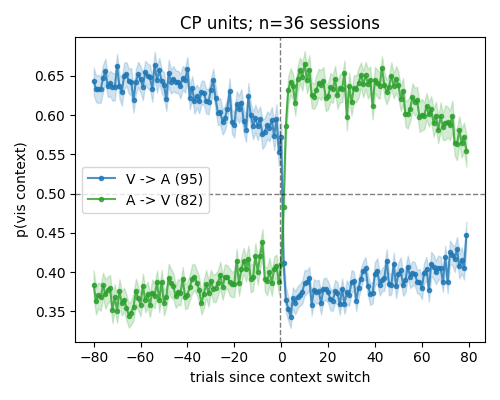

In [340]:
sel_area='CP'
dprime_threshold=1.0

sel_data=context_switch_predict_proba.query('area==@sel_area and dprime_before>=@dprime_threshold and dprime_after>=@dprime_threshold and project=="DynamicRouting"')

vis_to_aud_switch_mean=np.nanmean(np.vstack(sel_data.query('context_before=="vis" and context_after=="aud"')['predict_proba'].values),axis=0)
vis_to_aud_switch_sem=stats.sem(np.vstack(sel_data.query('context_before=="vis" and context_after=="aud"')['predict_proba'].values),axis=0,nan_policy='omit')
vis_to_aud_switch_n=len(sel_data.query('context_before=="vis" and context_after=="aud"'))
aud_to_vis_switch_mean=np.nanmean(np.vstack(sel_data.query('context_before=="aud" and context_after=="vis"')['predict_proba'].values),axis=0)
aud_to_vis_switch_sem=stats.sem(np.vstack(sel_data.query('context_before=="aud" and context_after=="vis"')['predict_proba'].values),axis=0,nan_policy='omit')
aud_to_vis_switch_n=len(sel_data.query('context_before=="aud" and context_after=="vis"'))

xvect=np.arange(-n_trials_before_switch,n_trials_after_switch) #x vector for plotting, trials since switch

fig,ax=plt.subplots(figsize=(5,4))
ax.plot(xvect,vis_to_aud_switch_mean,color='tab:blue',marker='.',label=f'V -> A ({vis_to_aud_switch_n})',alpha=0.8)
ax.fill_between(xvect,vis_to_aud_switch_mean-vis_to_aud_switch_sem,vis_to_aud_switch_mean+vis_to_aud_switch_sem,alpha=0.2,color='tab:blue')
ax.plot(xvect,aud_to_vis_switch_mean,color='tab:green',marker='.',label=f'A -> V ({aud_to_vis_switch_n})',alpha=0.8)
ax.fill_between(xvect,aud_to_vis_switch_mean-aud_to_vis_switch_sem,aud_to_vis_switch_mean+aud_to_vis_switch_sem,alpha=0.2,color='tab:green')

ax.axvline(-0.5,color='k',linewidth=1.0,alpha=0.5,linestyle='--')
ax.axhline(0.5,color='k',linewidth=1.0,alpha=0.5,linestyle='--')

ax.set_xlabel('trials since context switch')
ax.set_ylabel('p(vis context)')
ax.legend()

ax.set_title(sel_area+' units; n='+str(len(sel_data.query('switch_index==0')))+' sessions')

fig.tight_layout()


In [330]:
np.vstack(sel_data.query('context_before=="vis" and context_after=="aud"')['predict_proba'].values)

array([[0.71489828, 0.70900431, 0.82250422, ..., 0.8419381 , 0.65987912,
        0.62616482],
       [0.72445821, 0.64219415, 0.47720305, ...,        nan,        nan,
               nan],
       [0.5014164 , 0.61559279, 0.74536105, ..., 0.43520072, 0.45260327,
        0.5316301 ],
       ...,
       [0.51568925, 0.579958  , 0.53248963, ..., 0.44743527,        nan,
               nan],
       [0.56732795, 0.58532575, 0.56862021, ..., 0.23986329, 0.33167027,
        0.35072123],
       [0.72167704, 0.65798863, 0.69687921, ..., 0.60761259, 0.5418648 ,
        0.45854268]])

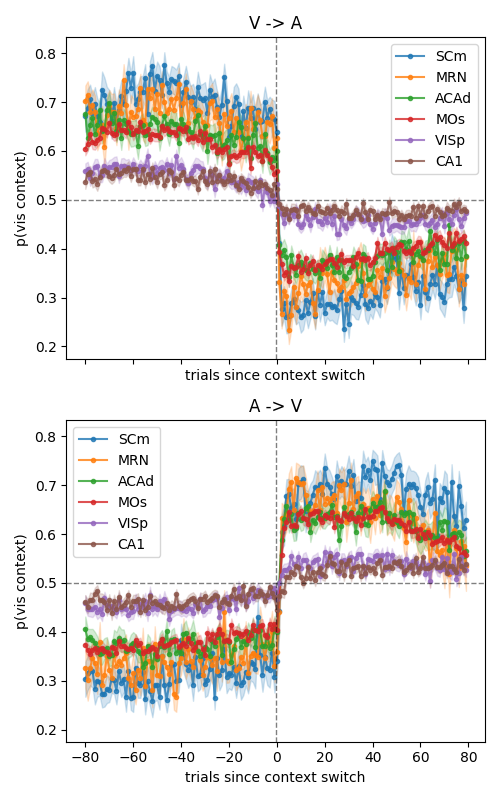

In [341]:
sel_areas=['SCm','MRN','ACAd','MOs','VISp','CA1']
dprime_threshold=1.0

fig,ax=plt.subplots(2,1,figsize=(5,8),sharex=True,sharey=True)

for sel_area in sel_areas:

    sel_data=context_switch_predict_proba.query('area==@sel_area and dprime_before>=@dprime_threshold and dprime_after>=@dprime_threshold and project=="DynamicRouting"')

    vis_to_aud_switch_mean=np.nanmean(np.vstack(sel_data.query('context_before=="vis" and context_after=="aud"')['predict_proba'].values),axis=0)
    vis_to_aud_switch_sem=stats.sem(np.vstack(sel_data.query('context_before=="vis" and context_after=="aud"')['predict_proba'].values),axis=0,nan_policy='omit')
    vis_to_aud_switch_n=len(sel_data.query('context_before=="vis" and context_after=="aud"'))
    aud_to_vis_switch_mean=np.nanmean(np.vstack(sel_data.query('context_before=="aud" and context_after=="vis"')['predict_proba'].values),axis=0)
    aud_to_vis_switch_sem=stats.sem(np.vstack(sel_data.query('context_before=="aud" and context_after=="vis"')['predict_proba'].values),axis=0,nan_policy='omit') # use omit to ignore nans in the calculation of the sem, otherwise it will return nan if any nans are present in the array
    aud_to_vis_switch_n=len(sel_data.query('context_before=="aud" and context_after=="vis"'))

    line=ax[0].plot(xvect,vis_to_aud_switch_mean,marker='.',label=sel_area,alpha=0.8)
    ax[0].fill_between(xvect,vis_to_aud_switch_mean-vis_to_aud_switch_sem,vis_to_aud_switch_mean+vis_to_aud_switch_sem,alpha=0.2,color=line[0].get_color())

    line=ax[1].plot(xvect,aud_to_vis_switch_mean,marker='.',label=sel_area,alpha=0.8)
    ax[1].fill_between(xvect,aud_to_vis_switch_mean-aud_to_vis_switch_sem,aud_to_vis_switch_mean+aud_to_vis_switch_sem,alpha=0.2,color=line[0].get_color())

ax[0].axvline(-0.5,color='k',linewidth=1.0,alpha=0.5,linestyle='--')
ax[1].axvline(-0.5,color='k',linewidth=1.0,alpha=0.5,linestyle='--')

ax[0].axhline(0.5,color='k',linewidth=1.0,alpha=0.5,linestyle='--')
ax[1].axhline(0.5,color='k',linewidth=1.0,alpha=0.5,linestyle='--')

ax[0].set_xlabel('trials since context switch')
ax[0].set_ylabel('p(vis context)')
ax[0].set_title('V -> A')
ax[0].legend()

ax[1].set_xlabel('trials since context switch')
ax[1].set_ylabel('p(vis context)')
ax[1].set_title('A -> V')
ax[1].legend()

fig.tight_layout()


In [126]:
#response type predict proba
response_type_predict_proba

,session_id,area,project,vis_context_dprime,aud_context_dprime,overall_dprime,n_good_blocks,vis_hit_predict_proba,vis_fa_predict_proba,vis_cr_predict_proba,...,aud_cr_predict_proba,correct_predict_proba,incorrect_predict_proba,cr_all_predict_proba,fa_all_predict_proba,hit_all_predict_proba,ccf_ap_mean,ccf_dv_mean,ccf_ml_mean,n_units
0,626791_2022-08-15,VPM,DynamicRouting,2.974365,1.991225,1.704476,5,0.626421,0.579132,0.647277,...,0.376569,0.5,0.5,0.638031,0.600327,0.610222,[6991.3865546218485],[4653.781512605042],[4351.470588235294],119
1,626791_2022-08-15,PO,DynamicRouting,2.974365,1.991225,1.704476,5,0.614973,0.574961,0.662520,...,0.309170,0.5,0.5,0.673498,0.600485,0.594166,[6853.084415584415],[3954.0584415584417],[4464.448051948052],154
2,626791_2022-08-15,LP,DynamicRouting,2.974365,1.991225,1.704476,5,0.572593,0.633962,0.614973,...,0.350722,0.5,0.5,0.628275,0.598870,0.576450,[6774.050632911392],[3462.974683544304],[4562.658227848101],79
3,626791_2022-08-15,LD,DynamicRouting,2.974365,1.991225,1.704476,5,0.532640,0.528926,0.543054,...,0.444452,0.5,0.5,0.547899,0.531904,0.523003,[6742.105263157895],[3267.1052631578946],[4596.0526315789475],38
4,626791_2022-08-15,RSPd,DynamicRouting,2.974365,1.991225,1.704476,5,0.574165,0.492751,0.671293,...,0.380508,0.5,0.5,0.651207,0.523483,0.572252,[6642.105263157895],[874.3421052631579],[5012.5],38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1803,742903_2024-10-24,MOp,DynamicRouting,2.549420,3.875863,2.339739,5,0.495483,0.531649,0.536715,...,0.477825,0.5,0.5,0.528475,0.519027,0.520832,[4101.056338028169],[2594.0140845070423],[3239.0845070422533],142
1804,742903_2024-10-24,all,DynamicRouting,2.549420,3.875863,2.339739,5,0.502367,0.522279,0.559804,...,0.439906,0.5,0.5,0.559968,0.510655,0.520231,[6452.969208211143],[3147.140762463343],[2822.4523460410555],1365
1805,742903_2024-10-24,CA1,DynamicRouting,2.549420,3.875863,2.339739,5,0.540592,0.560409,0.531143,...,0.467935,0.5,0.5,0.531665,0.550283,0.551436,[7710.416666666667],[2355.2083333333335],[2661.4583333333335],48
1806,742903_2024-10-24,CP,DynamicRouting,2.549420,3.875863,2.339739,5,0.520193,0.492178,0.565506,...,0.456969,0.5,0.5,0.552770,0.492398,0.537202,[5323.052959501558],[4030.841121495327],[3302.4143302180687],321


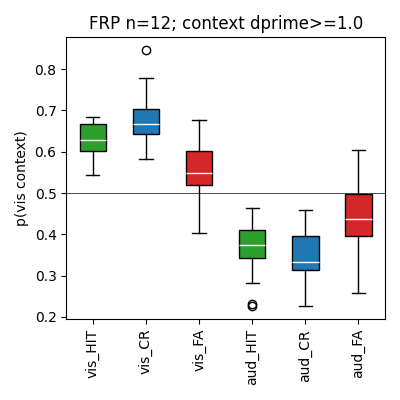

In [164]:
#cr vs. fa
dprime_threshold=1.0
sel_project='DynamicRouting'
min_n_recs=3

aa='FRP'

sel_area=response_type_predict_proba.query('area==@aa and vis_context_dprime>=@dprime_threshold and aud_context_dprime>=@dprime_threshold and project.str.contains(@sel_project)')

fig,ax=plt.subplots(1,1,figsize=(4,4))
#make boxplot of each response type
bplot=ax.boxplot(sel_area[['vis_hit_predict_proba','vis_cr_predict_proba','vis_fa_predict_proba',
                    'aud_hit_predict_proba','aud_cr_predict_proba','aud_fa_predict_proba']].values,
                    positions=[0,1,2,3,4,5],patch_artist=True,medianprops={"color": "white", "linewidth": 1.0},)

ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['vis_HIT','vis_CR','vis_FA','aud_HIT','aud_CR','aud_FA'],rotation=90)
fill_colors=['tab:green','tab:blue','tab:red','tab:green','tab:blue','tab:red']
# fill with colors
for patch, color in zip(bplot['boxes'], fill_colors):
    patch.set_facecolor(color)

ax.axhline(0.5,color='k',linewidth=0.5)
ax.set_title(str(aa)+' n='+str(len(sel_area))+'; context dprime>='+str(dprime_threshold))
ax.set_ylabel('p(vis context)')
# ax.set_ylim([0,1])

fig.tight_layout()

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15896\1543819338.py:26: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  cr_fa_diff_by_area['vis_context_cr_fa_diff_sem'].append(stats.sem(sel_area['vis_cr_predict_proba']-sel_area['vis_fa_predict_proba']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15896\1543819338.py:29: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  cr_fa_diff_by_area['aud_context_cr_fa_diff_sem'].append(stats.sem(sel_area['aud_cr_predict_proba']-sel_area['aud_fa_predict_proba']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15896\1543819338.py:33: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  cr_fa_diff_by_area['mean_diff_sem'].append(stats.sem(mean_diffs))


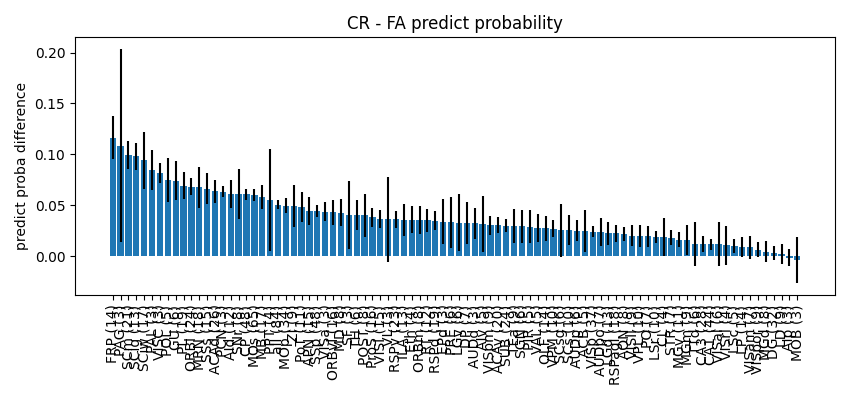

In [167]:
dprime_threshold=1.0
sel_project='DynamicRouting'
min_n_sessions=3

cr_fa_diff_by_area={
    'area':[],
    'n_sessions':[],
    'vis_context_dprime':[],
    'vis_context_cr_fa_diff':[],
    'vis_context_cr_fa_diff_sem':[],
    'aud_context_dprime':[],
    'aud_context_cr_fa_diff':[],
    'aud_context_cr_fa_diff_sem':[],
    'mean_diff':[],
    'mean_diff_sem':[],
    'total_diff':[],
}

for aa in response_type_predict_proba['area'].unique():
    # sel_area=decoder_confidence_versus_response_type.query('area==@aa and vis_context_dprime>=@dprime_threshold and aud_context_dprime>=@dprime_threshold and project.str.contains(@sel_project)')
    sel_area=response_type_predict_proba.query('area==@aa and n_good_blocks>=4 and project.str.contains(@sel_project)')
    cr_fa_diff_by_area['area'].append(aa)
    cr_fa_diff_by_area['n_sessions'].append(len(sel_area))
    cr_fa_diff_by_area['vis_context_dprime'].append(np.mean(sel_area['vis_context_dprime']))
    cr_fa_diff_by_area['vis_context_cr_fa_diff'].append(np.mean(sel_area['vis_cr_predict_proba']-sel_area['vis_fa_predict_proba']))
    cr_fa_diff_by_area['vis_context_cr_fa_diff_sem'].append(stats.sem(sel_area['vis_cr_predict_proba']-sel_area['vis_fa_predict_proba']))
    cr_fa_diff_by_area['aud_context_dprime'].append(np.mean(sel_area['aud_context_dprime']))
    cr_fa_diff_by_area['aud_context_cr_fa_diff'].append(np.mean(sel_area['aud_cr_predict_proba']-sel_area['aud_fa_predict_proba']))
    cr_fa_diff_by_area['aud_context_cr_fa_diff_sem'].append(stats.sem(sel_area['aud_cr_predict_proba']-sel_area['aud_fa_predict_proba']))
    cr_fa_diff_by_area['mean_diff'].append(np.mean(sel_area['cr_all_predict_proba']-sel_area['fa_all_predict_proba']))

    mean_diffs=(sel_area['vis_cr_predict_proba'].values+sel_area['aud_cr_predict_proba'].values)/2-(sel_area['vis_fa_predict_proba'].values+sel_area['aud_fa_predict_proba'].values)/2
    cr_fa_diff_by_area['mean_diff_sem'].append(stats.sem(mean_diffs))

    cr_fa_diff_by_area['total_diff'].append(np.sum([np.abs(cr_fa_diff_by_area['vis_context_cr_fa_diff'][-1]),np.abs(cr_fa_diff_by_area['aud_context_cr_fa_diff'][-1])]))


cr_fa_diff_by_area=pd.DataFrame(cr_fa_diff_by_area)

plot_data=cr_fa_diff_by_area.query('n_sessions>=@min_n_sessions').sort_values(by='mean_diff',ascending=False)

fig,ax=plt.subplots(figsize=(8.5,4))
ax.bar(plot_data['area'],plot_data['mean_diff'],yerr=plot_data['mean_diff_sem'])
# ax.bar(plot_data['area'],plot_data['vis_context_cr_fa_diff'])#,yerr=[plot_data['vis_context_cr_fa_diff_sem']])
# ax.bar(plot_data['area'],-plot_data['aud_context_cr_fa_diff'],bottom=plot_data['vis_context_cr_fa_diff'])#,yerr=[plot_data['aud_context_cr_fa_diff_sem']])
# plot_data.plot.bar(x='area',y='vis_context_cr_fa_diff',yerr=plot_data['vis_context_cr_fa_diff_sem'],ax=ax)

area_labels=[]
for i in range(plot_data.shape[0]):
    area_labels.append(plot_data['area'].iloc[i]+' ('+str(plot_data['n_sessions'].iloc[i])+')')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(area_labels,rotation=90,ha='center')
ax.set_ylabel('predict proba difference')

ax.set_title('CR - FA predict probability')

# ax.legend(['vis context','aud context'])

fig.tight_layout()


In [175]:
response_type_blockwise_predict_proba=pd.DataFrame(response_type_blockwise_predict_proba)

In [176]:
response_type_blockwise_predict_proba

,session_id,area,project,block_number,is_vis_context,is_aud_context,block_dprime,hit_predict_proba,fa_predict_proba,cr_predict_proba,correct_predict_proba,incorrect_predict_proba,ccf_ap_mean,ccf_dv_mean,ccf_ml_mean,n_units
0,626791_2022-08-15,VPM,DynamicRouting,0,True,False,2.974365,0.682756,0.795697,0.662883,0.509675,0.542966,[6991.3865546218485],[4653.781512605042],[4351.470588235294],119
1,626791_2022-08-15,VPM,DynamicRouting,1,False,True,1.991225,0.422638,0.240745,0.393866,0.462040,0.495070,[6991.3865546218485],[4653.781512605042],[4351.470588235294],119
2,626791_2022-08-15,VPM,DynamicRouting,2,True,False,1.373955,0.620489,0.543336,0.683410,0.490549,0.531183,[6991.3865546218485],[4653.781512605042],[4351.470588235294],119
3,626791_2022-08-15,VPM,DynamicRouting,3,False,True,0.000000,0.462296,0.462916,NaN,0.469408,0.514158,[6991.3865546218485],[4653.781512605042],[4351.470588235294],119
4,626791_2022-08-15,VPM,DynamicRouting,4,True,False,1.774796,0.572230,0.553537,0.591531,0.486176,0.532609,[6991.3865546218485],[4653.781512605042],[4351.470588235294],119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10843,742903_2024-10-24,SSp,DynamicRouting,1,True,False,2.549420,0.440854,0.390883,0.489873,0.504299,0.424931,[6422.972972972973],[2194.0033783783783],[2377.5337837837837],296
10844,742903_2024-10-24,SSp,DynamicRouting,2,False,True,3.212084,0.490881,0.490926,0.462153,0.506423,0.432681,[6422.972972972973],[2194.0033783783783],[2377.5337837837837],296
10845,742903_2024-10-24,SSp,DynamicRouting,3,True,False,2.239216,0.576398,0.571160,0.598233,0.521844,0.447933,[6422.972972972973],[2194.0033783783783],[2377.5337837837837],296
10846,742903_2024-10-24,SSp,DynamicRouting,4,False,True,2.856932,0.580766,0.576436,0.572291,0.521701,0.440550,[6422.972972972973],[2194.0033783783783],[2377.5337837837837],296


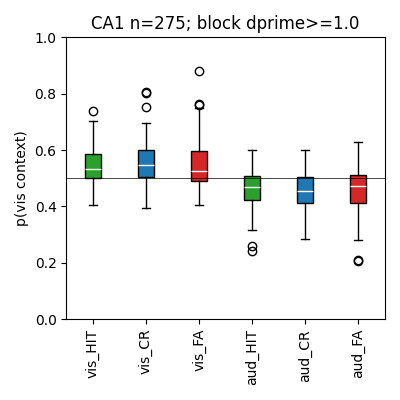

In [302]:
#cr vs. fa

###why are there nans??###  --prevent them or deal with them

dprime_threshold=1.0
sel_project='DynamicRouting'

aa='CA1'

sel_area=response_type_blockwise_predict_proba.query('area==@aa and block_dprime>=@dprime_threshold and project.str.contains(@sel_project)')

fig,ax=plt.subplots(1,1,figsize=(4,4))
#make boxplot of each response type
bplot0=ax.boxplot([sel_area.query('is_vis_context and ~hit_predict_proba.isna()')['hit_predict_proba'],
                    sel_area.query('is_vis_context and ~cr_predict_proba.isna()')['cr_predict_proba'],
                    sel_area.query('is_vis_context and ~fa_predict_proba.isna()')['fa_predict_proba']],
                    positions=[0,1,2],patch_artist=True,medianprops={"color": "white", "linewidth": 1.0},)

bplot1=ax.boxplot([sel_area.query('is_aud_context and ~hit_predict_proba.isna()')['hit_predict_proba'],
                    sel_area.query('is_aud_context and ~cr_predict_proba.isna()')['cr_predict_proba'],
                    sel_area.query('is_aud_context and ~fa_predict_proba.isna()')['fa_predict_proba']],
                    positions=[3,4,5],patch_artist=True,medianprops={"color": "white", "linewidth": 1.0},)

ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['vis_HIT','vis_CR','vis_FA','aud_HIT','aud_CR','aud_FA'],rotation=90)
fill_colors=['tab:green','tab:blue','tab:red']
# fill with colors
for patch, color in zip(bplot0['boxes'], fill_colors):
    patch.set_facecolor(color)
for patch, color in zip(bplot1['boxes'], fill_colors):
    patch.set_facecolor(color)

ax.axhline(0.5,color='k',linewidth=0.5)
ax.set_title(str(aa)+' n='+str(len(sel_area))+'; block dprime>='+str(dprime_threshold))
ax.set_ylabel('p(vis context)')
ax.set_ylim([0,1])

fig.tight_layout()

In [303]:
#cr vs fa blockwise
dprime_threshold=1.0
sel_project='DynamicRouting'
min_n_blocks=18

cr_fa_diff_by_area_blockwise={
    'area':[],
    'n_blocks':[],
    'vis_context_dprime':[],
    'vis_context_cr_fa_diff':[],
    'vis_context_cr_fa_diff_sem':[],
    'aud_context_dprime':[],
    'aud_context_cr_fa_diff':[],
    'aud_context_cr_fa_diff_sem':[],
    'mean_diff':[],
    'mean_diff_sem':[],
    # 'total_diff':[],
}

for aa in response_type_blockwise_predict_proba['area'].unique():
    sel_area=response_type_blockwise_predict_proba.query('area==@aa and project.str.contains(@sel_project) and block_dprime>=@dprime_threshold')
    cr_fa_diff_by_area_blockwise['area'].append(aa)
    cr_fa_diff_by_area_blockwise['n_blocks'].append(len(sel_area))
    cr_fa_diff_by_area_blockwise['vis_context_dprime'].append(np.nanmean(sel_area.query('is_vis_context')['block_dprime']))
    cr_fa_diff_by_area_blockwise['vis_context_cr_fa_diff'].append(np.nanmean(sel_area.query('is_vis_context')['cr_predict_proba']-sel_area.query('is_vis_context')['fa_predict_proba']))
    cr_fa_diff_by_area_blockwise['vis_context_cr_fa_diff_sem'].append(stats.sem(sel_area.query('is_vis_context')['cr_predict_proba']-sel_area.query('is_vis_context')['fa_predict_proba'],nan_policy='omit'))
    cr_fa_diff_by_area_blockwise['aud_context_dprime'].append(np.nanmean(sel_area.query('is_aud_context')['block_dprime']))
    cr_fa_diff_by_area_blockwise['aud_context_cr_fa_diff'].append(np.nanmean(sel_area.query('is_aud_context')['cr_predict_proba']-sel_area.query('is_aud_context')['fa_predict_proba']))
    cr_fa_diff_by_area_blockwise['aud_context_cr_fa_diff_sem'].append(stats.sem(sel_area.query('is_aud_context')['cr_predict_proba']-sel_area.query('is_aud_context')['fa_predict_proba'],nan_policy='omit'))
    
    all_cr_fa_diffs=np.hstack(
        [sel_area.query('is_vis_context')['cr_predict_proba']-sel_area.query('is_vis_context')['fa_predict_proba'],
        -(sel_area.query('is_aud_context')['cr_predict_proba']-sel_area.query('is_aud_context')['fa_predict_proba'])]
        )

    cr_fa_diff_by_area_blockwise['mean_diff'].append(np.nanmean(all_cr_fa_diffs))
    cr_fa_diff_by_area_blockwise['mean_diff_sem'].append(stats.sem(all_cr_fa_diffs,nan_policy='omit'))

    # mean_diffs=(sel_area.query('is_vis_context')['cr_predict_proba'].values+sel_area.query('is_aud_context')['cr_predict_proba'].values)/2-(sel_area.query('is_vis_context')['fa_predict_proba'].values+sel_area.query('is_aud_context')['fa_predict_proba'].values)/2
    # cr_fa_diff_by_area_blockwise['mean_diff_sem'].append(stats.sem(mean_diffs))

    # cr_fa_diff_by_area_blockwise['total_diff'].append(np.sum([np.abs(cr_fa_diff_by_area_blockwise['vis_context_cr_fa_diff'][-1]),np.abs(cr_fa_diff_by_area_blockwise['aud_context_cr_fa_diff'][-1])]))

cr_fa_diff_by_area_blockwise=pd.DataFrame(cr_fa_diff_by_area_blockwise)



C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15896\2478840400.py:26: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  cr_fa_diff_by_area_blockwise['vis_context_cr_fa_diff_sem'].append(stats.sem(sel_area.query('is_vis_context')['cr_predict_proba']-sel_area.query('is_vis_context')['fa_predict_proba'],nan_policy='omit'))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15896\2478840400.py:27: RuntimeWarning: Mean of empty slice
  cr_fa_diff_by_area_blockwise['aud_context_dprime'].append(np.nanmean(sel_area.query('is_aud_context')['block_dprime']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_15896\2478840400.py:28: RuntimeWarning: Mean of empty slice
  cr_fa_diff_by_area_blockwise['aud_context_cr_fa_diff'].append(np.nanmean(sel_area.query('is_aud_context')['cr_predict_proba']-sel_area.query('is_aud_context')['fa_predict_proba']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipyke

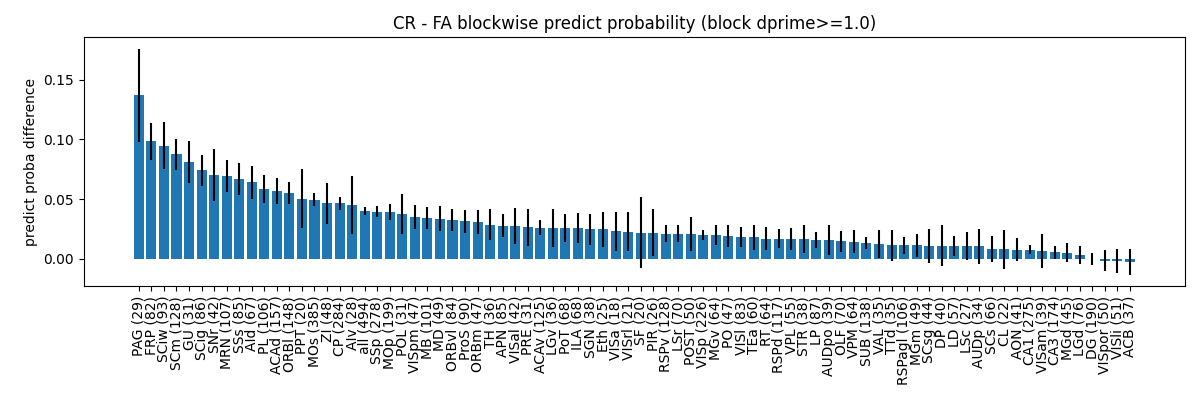

In [304]:
plot_data=cr_fa_diff_by_area_blockwise.query('n_blocks>=@min_n_blocks').sort_values(by='mean_diff',ascending=False)

fig,ax=plt.subplots(figsize=(12,4))
ax.bar(plot_data['area'],plot_data['mean_diff'],yerr=plot_data['mean_diff_sem'])
# ax.bar(plot_data['area'],plot_data['vis_context_cr_fa_diff'])#,yerr=[plot_data['vis_context_cr_fa_diff_sem']])
# ax.bar(plot_data['area'],-plot_data['aud_context_cr_fa_diff'],bottom=plot_data['vis_context_cr_fa_diff'])#,yerr=[plot_data['aud_context_cr_fa_diff_sem']])
# plot_data.plot.bar(x='area',y='vis_context_cr_fa_diff',yerr=plot_data['vis_context_cr_fa_diff_sem'],ax=ax)

area_labels=[]
for i in range(plot_data.shape[0]):
    area_labels.append(plot_data['area'].iloc[i]+' ('+str(plot_data['n_blocks'].iloc[i])+')')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(area_labels,rotation=90,ha='center')
ax.set_ylabel('predict proba difference')

ax.set_title('CR - FA blockwise predict probability (block dprime>='+str(dprime_threshold)+')')

# ax.legend(['vis context','aud context'])

fig.tight_layout()

In [249]:
sel_project='DynamicRouting'
unique_sessions=decoder_confidence_all_trials.query('project==@sel_project')['session'].unique()


# #for each unique session
for ss,session_id in enumerate(unique_sessions):

    session_confidence=decoder_confidence_all_trials.query('session==@session_id and (probe=="" or probe=="all")')
    session_areas=session_confidence['area'].unique()

    #load trials table & performance table
    trials=pd.read_parquet(npc_lims.get_cache_path('trials',version='0.0.265',session_id=session_id))
    performance=pd.read_parquet(npc_lims.get_cache_path('performance',version='0.0.265',session_id=session_id))

    # add blockwise and session-wide performance to trials table
    for block_index in trials['block_index'].unique():
        block_performance=performance.query('block_index==@block_index')
        trials.loc[trials['block_index']==block_index,'block_dprime']=block_performance['cross_modal_dprime'].values[0]
    trials['session_dprime']=performance['cross_modal_dprime'].mean()
    trials['session_id']=session_id

    for aa in session_areas:
        # aa=session_areas[0]
        area_confidence=session_confidence.query('area==@aa')
        if len(area_confidence)==0:
            continue
        area_predict_proba=area_confidence['predict_proba'].values[0]

        trials[aa+'_predict_proba']=area_predict_proba

    if ss==0:
        all_trials_with_decoder_confidence=trials
    else:
        all_trials_with_decoder_confidence=pd.concat([all_trials_with_decoder_confidence,trials],axis=0,ignore_index=True)
        



In [250]:
all_trials_with_decoder_confidence['session_id'].unique()

array(['626791_2022-08-15', '626791_2022-08-16', '626791_2022-08-17',
       '636766_2023-01-23', '636766_2023-01-24', '644864_2023-02-02',
       '644866_2023-02-07', '644866_2023-02-08', '644866_2023-02-09',
       '644866_2023-02-10', '644867_2023-02-20', '644867_2023-02-22',
       '644867_2023-02-23', '649943_2023-02-13', '649943_2023-02-14',
       '649943_2023-02-15', '649943_2023-02-16', '660023_2023-08-09',
       '662892_2023-08-21', '662892_2023-08-22', '662892_2023-08-23',
       '662892_2023-08-24', '664851_2023-11-13', '664851_2023-11-14',
       '664851_2023-11-15', '664851_2023-11-16', '666986_2023-08-14',
       '666986_2023-08-15', '666986_2023-08-17', '667252_2023-09-26',
       '667252_2023-09-28', '668755_2023-08-28', '668755_2023-08-29',
       '668755_2023-08-30', '668755_2023-08-31', '674562_2023-10-02',
       '674562_2023-10-03', '674562_2023-10-04', '674562_2023-10-05',
       '676909_2023-12-11', '676909_2023-12-12', '676909_2023-12-13',
       '676909_2023-

In [251]:
all_trials_with_decoder_confidence.columns

Index(['start_time', 'stop_time', 'quiescent_start_time',
       'quiescent_stop_time', 'stim_start_time', 'stim_stop_time',
       'response_window_start_time', 'response_window_stop_time',
       'task_control_response_time', 'response_time',
       ...
       'AIp_predict_proba', 'VISC_predict_proba', 'FF_predict_proba',
       'PIL_predict_proba', 'NOT_predict_proba', 'SPFp_predict_proba',
       'ENTl_predict_proba', 'VTA_predict_proba', 'IntG_predict_proba',
       'LA_predict_proba'],
      dtype='object', length=211)

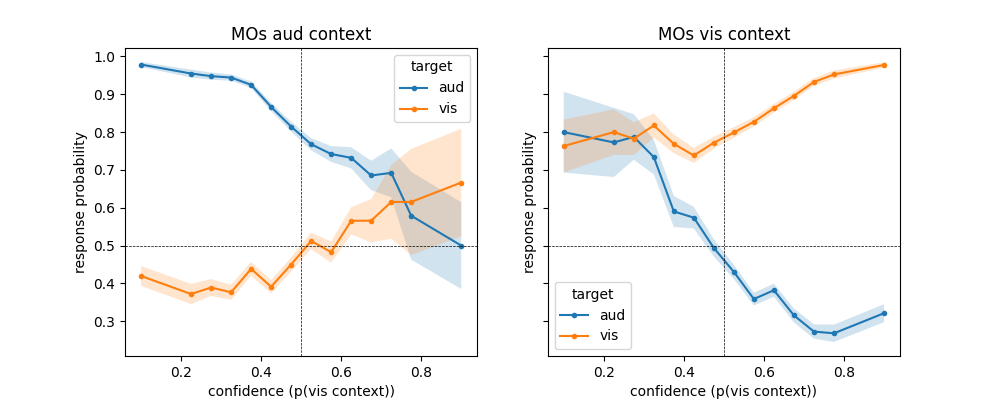

In [342]:
sel_area='MOs'

targets=['aud','vis']
contexts=['aud','vis']
# dprime_threshold=1.0
conf_bins=np.array([0,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,1.0])
conf_bin_midpoints=conf_bins[:-1]+np.diff(conf_bins)/2

fig,ax=plt.subplots(1,2,figsize=(10,4),sharex=True,sharey=True)

for sel_context in contexts:

    if sel_context=='aud':
        axind=0
    elif sel_context=='vis':
        axind=1

    for sel_target in targets:

        area_predict_proba=all_trials_with_decoder_confidence.query('is_'+sel_context+'_context and is_'+sel_target+'_target')[[sel_area+'_predict_proba','is_response']]
        # area_predict_proba=all_trials_with_decoder_confidence.query('is_'+sel_context+'_context and is_'+sel_target+'_target and block_dprime>=@dprime_threshold')[[sel_area+'_predict_proba','is_response']]

        predict_proba_bins=pd.cut(area_predict_proba[sel_area+'_predict_proba'],bins=conf_bins,labels=False)
        area_predict_proba['predict_proba_bins']=predict_proba_bins

        mean_bin_values=[]
        bin_sems=[]

        for bb in range(len(conf_bins[:-1])):
            bin_data=area_predict_proba.query('@predict_proba_bins==@bb')
            mean_bin_values.append(np.nanmean(bin_data['is_response']))
            bin_sems.append(stats.sem(bin_data['is_response'],nan_policy='omit'))

        # ax.errorbar(conf_bin_midpoints,mean_bin_values,yerr=bin_sems,marker='.')
        ax[axind].plot(conf_bin_midpoints,mean_bin_values,marker='.',label=sel_target)
        ax[axind].fill_between(conf_bin_midpoints,np.array(mean_bin_values)-np.array(bin_sems),np.array(mean_bin_values)+np.array(bin_sems),alpha=0.2)
        ax[axind].set_xlabel('confidence (p(vis context))')
        ax[axind].set_ylabel('response probability')
        ax[axind].set_title(sel_area+' '+sel_context+' context')

    ax[axind].axvline(0.5,color='k',linewidth=0.5,linestyle='--')
    ax[axind].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
    ax[axind].legend(title='target')



In [275]:
conf_bin_midpoints.shape[0]
len(mean_bin_values)

15

In [254]:
# all_trials_with_decoder_confidence.query('is_vis_context and is_vis_target')

In [225]:
area_confidence['predict_proba']

Series([], Name: predict_proba, dtype: object)

In [127]:
before_after_target_predict_proba

,session_id,area,project,cross_modal_dprime,n_good_blocks,rewarded_target,rewarded_target_plus_one,non_rewarded_target,non_rewarded_target_plus_one,non_response_non_rewarded_target,non_response_non_rewarded_target_plus_one,non_response_non_target_trials,non_response_non_target_trials_plus_one,ccf_ap_mean,ccf_dv_mean,ccf_ml_mean,n_units
0,626791_2022-08-15,VPM,DynamicRouting,1.704476,5,"[0.741496344068227, 0.668832634853393, 0.73125...","[0.7922991763466287, 0.7549364240537897, 0.825...","[0.7547118877530137, 0.8250293404094827, 0.807...","[0.7031236579806688, 0.7623406373380884, 0.603...","[0.8386251433052496, 0.6755607442583665, 0.859...","[0.8752220457896632, 0.8783344439904205, 0.668...","[0.8443291265984959, 0.7922991763466287, 0.717...","[0.741496344068227, 0.7657245801968428, 0.6755...","0 6991.386555 Name: ccf_ap_mean, dtype: flo...","0 4653.781513 Name: ccf_dv_mean, dtype: flo...","0 4351.470588 Name: ccf_ml_mean, dtype: flo...","0 119 Name: n_units, dtype: int64"
1,626791_2022-08-15,PO,DynamicRouting,1.704476,5,"[0.7230287976208116, 0.7248559251054308, 0.796...","[0.8270956945326319, 0.8308556660065952, 0.845...","[0.7866656352153667, 0.8454302624340638, 0.769...","[0.8316936396022041, 0.7576541446585341, 0.773...","[0.8989938945524416, 0.8400816442089595, 0.823...","[0.895012290069318, 0.8831352000692084, 0.7248...","[0.8131412725863596, 0.8270956945326319, 0.827...","[0.7230287976208116, 0.8090225297435454, 0.840...","1 6853.084416 Name: ccf_ap_mean, dtype: flo...","1 3954.058442 Name: ccf_dv_mean, dtype: flo...","1 4464.448052 Name: ccf_ml_mean, dtype: flo...","1 154 Name: n_units, dtype: int64"
2,626791_2022-08-15,LP,DynamicRouting,1.704476,5,"[0.6559911478738456, 0.7002455367216797, 0.798...","[0.746589278088264, 0.7916406343010113, 0.8191...","[0.8379385324153565, 0.819177777934404, 0.7690...","[0.657593417014245, 0.6896090481483463, 0.7536...","[0.7966084530133005, 0.7339709585328525, 0.795...","[0.7798979523096813, 0.8334039012376482, 0.700...","[0.8110551433872922, 0.746589278088264, 0.8355...","[0.6559911478738456, 0.692951084581148, 0.7339...","2 6774.050633 Name: ccf_ap_mean, dtype: flo...","2 3462.974684 Name: ccf_dv_mean, dtype: flo...","2 4562.658228 Name: ccf_ml_mean, dtype: flo...","2 79 Name: n_units, dtype: int64"
3,626791_2022-08-15,LD,DynamicRouting,1.704476,5,"[0.544310637050944, 0.4791952809134349, 0.6042...","[0.6633153426840864, 0.6652239032624975, 0.708...","[0.7391249602996288, 0.7085934330545455, 0.632...","[0.6641414997358224, 0.46079440687816364, 0.69...","[0.6524571657334071, 0.6872306393289808, 0.705...","[0.7351461719705635, 0.6957803397774677, 0.479...","[0.7025651484043111, 0.6633153426840864, 0.748...","[0.544310637050944, 0.7637108340708546, 0.6872...","3 6742.105263 Name: ccf_ap_mean, dtype: flo...","3 3267.105263 Name: ccf_dv_mean, dtype: flo...","3 4596.052632 Name: ccf_ml_mean, dtype: flo...","3 38 Name: n_units, dtype: int64"
4,626791_2022-08-15,RSPd,DynamicRouting,1.704476,5,"[0.813632946993425, 0.8462545583919673, 0.8587...","[0.8159048829643035, 0.9174874211150776, 0.703...","[0.6755902970612481, 0.7031642190201539, 0.670...","[0.696970620841053, 0.745355272519242, 0.68305...","[0.7919523355233017, 0.8678409708685456, 0.691...","[0.7747296363151225, 0.8616879368546183, 0.846...","[0.9067726949936545, 0.8159048829643035, 0.819...","[0.813632946993425, 0.6704793633302861, 0.8678...","5 6642.105263 Name: ccf_ap_mean, dtype: flo...","5 874.342105 Name: ccf_dv_mean, dtype: float64","5 5012.5 Name: ccf_ml_mean, dtype: float64","5 38 Name: n_units, dtype: int64"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1803,742903_2024-10-24,MOp,DynamicRouting,2.339739,5,"[0.7025436879434668, 0.7782657972463369, 0.651...","[0.7081810343941329, 0.6682905826973351, 0.685...","[0.46736264520079784, 0.4040868366857498, 0.42...","[0.47182370437383375, 0.4522477591243398, 0.46...","[0.5119287864023403, 0.7220395540107816, 0.654...","[0.7346199634224879, 0.6545074038401155,

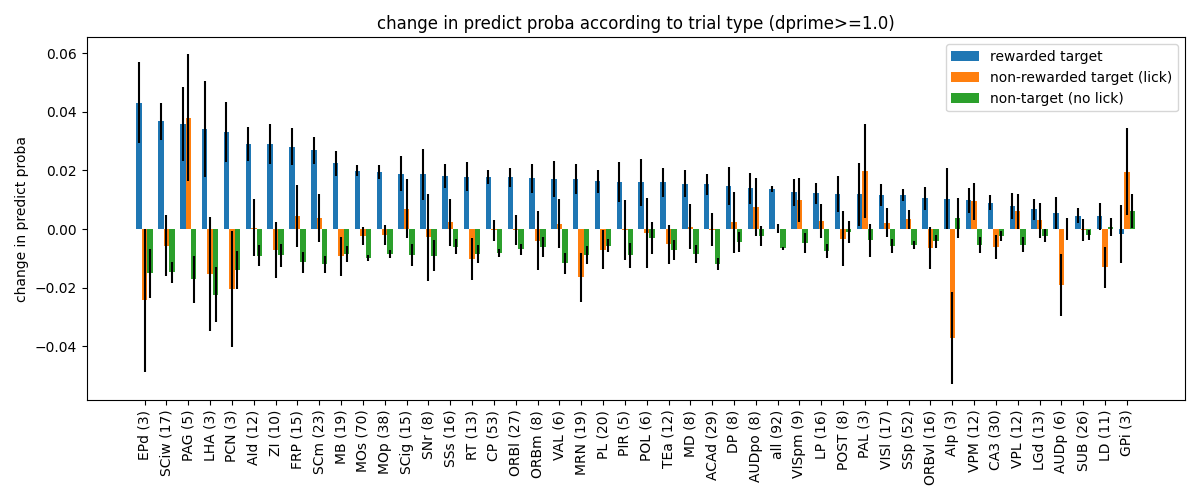

In [170]:
#plot change in decoder confidence by area

sel_project='DynamicRouting'
min_n_sessions=3
min_dprime=1.0
first_avg_session=False

change_in_decoder_confidence_by_trial_type_area={
    'area':[],
    'n_sessions':[],
    'rewarded_target':[],	
    'rewarded_target_plus_one':[],
    'rewarded_target_diff_mean':[],
    'rewarded_target_diff_sem':[],
    'rewarded_target_diff_p':[],
    'non_rewarded_target':[],	
    'non_rewarded_target_plus_one':[],
    'non_rewarded_target_diff_mean':[],
    'non_rewarded_target_diff_sem':[],
    'non_rewarded_target_diff_p':[],
    'non_rewarded_target_no_lick':[],
    'non_rewarded_target_no_lick_plus_one':[],
    'non_rewarded_target_no_lick_diff_mean':[],
    'non_rewarded_target_no_lick_diff_sem':[],
    'non_rewarded_target_no_lick_diff_p':[],
    'non_target_no_lick':[],
    'non_target_no_lick_plus_one':[],
    'non_target_no_lick_diff_mean':[],
    'non_target_no_lick_diff_sem':[],
    'non_target_no_lick_diff_p':[],

}

col_list=['rewarded_target','rewarded_target_plus_one','non_rewarded_target','non_rewarded_target_plus_one',
            'non_response_non_rewarded_target','non_response_non_rewarded_target_plus_one',
            'non_response_non_target_trials','non_response_non_target_trials_plus_one']

for aa in before_after_target_predict_proba['area'].unique():
    sel_area=before_after_target_predict_proba.query('area==@aa and project.str.contains(@sel_project) and cross_modal_dprime>=@min_dprime')
    if len(sel_area)==0:
        continue

    change_in_decoder_confidence_by_trial_type_area['area'].append(aa)
    change_in_decoder_confidence_by_trial_type_area['n_sessions'].append(len(sel_area))
    change_in_decoder_confidence_by_trial_type_area['rewarded_target'].append(np.hstack(sel_area['rewarded_target']))
    change_in_decoder_confidence_by_trial_type_area['rewarded_target_plus_one'].append(np.hstack(sel_area['rewarded_target_plus_one']))
    change_in_decoder_confidence_by_trial_type_area['rewarded_target_diff_mean'].append(np.nanmean(np.hstack(sel_area['rewarded_target_plus_one']-sel_area['rewarded_target'])))
    change_in_decoder_confidence_by_trial_type_area['rewarded_target_diff_sem'].append(stats.sem(np.hstack(sel_area['rewarded_target_plus_one']-sel_area['rewarded_target'])))
    change_in_decoder_confidence_by_trial_type_area['rewarded_target_diff_p'].append(stats.wilcoxon(np.hstack(sel_area['rewarded_target_plus_one']),np.hstack(sel_area['rewarded_target']))[1])

    change_in_decoder_confidence_by_trial_type_area['non_rewarded_target'].append(sel_area['non_rewarded_target'])
    change_in_decoder_confidence_by_trial_type_area['non_rewarded_target_plus_one'].append(sel_area['non_rewarded_target_plus_one'])
    change_in_decoder_confidence_by_trial_type_area['non_rewarded_target_diff_mean'].append(np.nanmean(np.hstack(sel_area['non_rewarded_target_plus_one']-sel_area['non_rewarded_target'])))
    change_in_decoder_confidence_by_trial_type_area['non_rewarded_target_diff_sem'].append(stats.sem(np.hstack(sel_area['non_rewarded_target_plus_one']-sel_area['non_rewarded_target'])))
    change_in_decoder_confidence_by_trial_type_area['non_rewarded_target_diff_p'].append(stats.wilcoxon(np.hstack(sel_area['non_rewarded_target_plus_one']),np.hstack(sel_area['non_rewarded_target']))[1])

    change_in_decoder_confidence_by_trial_type_area['non_rewarded_target_no_lick'].append(sel_area['non_response_non_rewarded_target'])
    change_in_decoder_confidence_by_trial_type_area['non_rewarded_target_no_lick_plus_one'].append(sel_area['non_response_non_rewarded_target_plus_one'])
    change_in_decoder_confidence_by_trial_type_area['non_rewarded_target_no_lick_diff_mean'].append(np.nanmean(np.hstack(sel_area['non_response_non_rewarded_target_plus_one']-sel_area['non_response_non_rewarded_target'])))
    change_in_decoder_confidence_by_trial_type_area['non_rewarded_target_no_lick_diff_sem'].append(stats.sem(np.hstack(sel_area['non_response_non_rewarded_target_plus_one']-sel_area['non_response_non_rewarded_target'])))
    change_in_decoder_confidence_by_trial_type_area['non_rewarded_target_no_lick_diff_p'].append(stats.wilcoxon(np.hstack(sel_area['non_response_non_rewarded_target_plus_one']),np.hstack(sel_area['non_response_non_rewarded_target']))[1])
    
    change_in_decoder_confidence_by_trial_type_area['non_target_no_lick'].append(sel_area['non_response_non_target_trials'])
    change_in_decoder_confidence_by_trial_type_area['non_target_no_lick_plus_one'].append(sel_area['non_response_non_target_trials_plus_one'])
    change_in_decoder_confidence_by_trial_type_area['non_target_no_lick_diff_mean'].append(np.nanmean(np.hstack(sel_area['non_response_non_target_trials_plus_one']-sel_area['non_response_non_target_trials'])))
    change_in_decoder_confidence_by_trial_type_area['non_target_no_lick_diff_sem'].append(stats.sem(np.hstack(sel_area['non_response_non_target_trials_plus_one']-sel_area['non_response_non_target_trials'])))
    change_in_decoder_confidence_by_trial_type_area['non_target_no_lick_diff_p'].append(stats.wilcoxon(np.hstack(sel_area['non_response_non_target_trials_plus_one']),np.hstack(sel_area['non_response_non_target_trials']))[1])

change_in_decoder_confidence_by_trial_type_area=pd.DataFrame(change_in_decoder_confidence_by_trial_type_area)

plot_data=change_in_decoder_confidence_by_trial_type_area.query('n_sessions>=@min_n_sessions and \
                                                                (rewarded_target_diff_p<0.05 or \
                                                                non_rewarded_target_diff_p<0.05 or \
                                                                non_rewarded_target_no_lick_diff_p<0.05 or \
                                                                non_target_no_lick_diff_p<0.05)').sort_values(by='rewarded_target_diff_mean',ascending=False)

xvect=np.arange(len(plot_data))

fig,ax=plt.subplots(figsize=(12,5))
ax.bar(xvect-0.25,plot_data['rewarded_target_diff_mean'],yerr=plot_data['rewarded_target_diff_sem'],width=0.25)
ax.bar(xvect,plot_data['non_rewarded_target_diff_mean'],yerr=plot_data['non_rewarded_target_diff_sem'],width=0.25)
# ax.bar(xvect+0.1,plot_data['non_rewarded_target_no_lick_diff_mean'],yerr=plot_data['non_rewarded_target_no_lick_diff_sem'],width=0.2)
ax.bar(xvect+0.25,plot_data['non_target_no_lick_diff_mean'],yerr=plot_data['non_target_no_lick_diff_sem'],width=0.25)
# ax.legend(['rewarded target','non-rewarded target (lick)','non-rewarded target (no lick)','non-target (no lick)'])
ax.legend(['rewarded target','non-rewarded target (lick)','non-target (no lick)'])

area_labels=[]
for i in range(plot_data.shape[0]):
    area_labels.append(plot_data['area'].iloc[i]+' ('+str(plot_data['n_sessions'].iloc[i])+')')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(area_labels,rotation=90,ha='center')
ax.set_ylabel('change in predict proba')

ax.set_title('change in predict proba according to trial type ('+'dprime>='+str(min_dprime)+')')

# ax.legend(['vis context','aud context'])

fig.tight_layout()


